# Differential Expression Analysis using PyDeSeq2
# [GSE129046 (Vitis Vinifera)](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE129046)
### Title
RNA-seq revealed counter effect of chitosan against Botrytis cinerea on grape berries
### Design
Two Grape verities (Shine-muscat and Kyoho) treated with resistance inducers chitosan, the physiological changes in the grape berry were analyzed at 80-90 % physiologically maturities, with commercial grade chitosan, formulations were applied by foliar spray: 15% (w/v) chitosan (15 kDa) (Fig.1). To prepare formulations, we used distilled water as control. Each berry of grapy is treated as one replication and each replication is repeated together and randomized 3 times. One day later, Botrytis cinerea spores with 104 /μl concentration was used. The gray mold fungus was grown on grape berries at 25 °C, and 95 % relative humidity.
### Sample ID's
* GSM3692243    KC1: Kyoho control
* GSM3692244	KC2: Kyoho control
* GSM3692245	KC3: Kyoho control
* GSM3692246	KT1: Kyoho Botrytis cinerea treatment
* GSM3692247	KT2: Kyoho Botrytis cinerea treatment
* GSM3692248	KT3: Kyoho Botrytis cinerea treatment
* GSM3692249	SC1: Shine-muscat control
* GSM3692250	SC2: Shine-muscat control
* GSM3692251	SC3: Shine-muscat control
* GSM3692252	ST1: Shine-muscat Botrytis cinerea treatment
* GSM3692253	ST2: Shine-muscat Botrytis cinerea treatment
* GSM3692254	ST3: Shine-muscat Botrytis cinerea treatment
#### Name: Aniket Yadav (20BTBINF003)

In [1]:
# %pip install pydeseq2
# %pip install scanpy # for performing PCA analysis
# %pip install sanbomics # use to convert ENS id's to gene symbols
# %pip install gseapy # python package for gene set enrichment analysis

In [2]:
# Import libraries
# type: ignore
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from pydeseq2.dds import DeseqDataSet 
from pydeseq2.ds import DeseqStats
import scanpy as sp
import gseapy as gea
from gseapy import dotplot, barplot

In [21]:
shineMuscat_file = "B:/Major_project/Workspace/GSE129046_family/Analysis/GSE129046_ShineMuscatCounts.csv"
kyoho_file = "B:/Major_project/Workspace/GSE129046_family/Analysis/GSE129046_KyohoCounts.csv"

(smdf, kdf) = (pd.read_csv(shineMuscat_file), pd.read_csv(kyoho_file))
(smcounts, kcounts) = (smdf.set_index('Gene_id'), kdf.set_index('Gene_id'))
(sm_counts, k_counts) = (smcounts.iloc[:,5:], kcounts.iloc[:,5:])
(smcounts, kcounts) = (sm_counts[sm_counts.sum(axis=1) > 0], k_counts[k_counts.sum(axis=1) > 0])
kcounts

KC1_readcount  KC2_readcount  KC3_readcount  \
Gene_id                                                           
Novel00001                      1              4              1   
Novel00002                   4920           3564           2117   
Novel00003                    310            252            177   
Novel00004                     36             31             42   
Novel00005                     59             58             29   
...                           ...            ...            ...   
VIT_219s0177g00320            259            260            207   
VIT_219s0177g00340             84            189             91   
VIT_219s0177g00350             39             55             25   
VIT_219s0177g00360           1318           1286            918   
VIT_219s0177g00366              0              1              1   

                    KT1_readcount  KT2_readcount  KT3_readcount  
Gene_id                                                          
Novel00001                      4              3              8  
Novel00002                    195             85            116  
Novel00003                    434            492            390  
Novel00004                     48             31             71  
Novel00005                     85            111            137  
...                           ...            ...            ...  
VIT_219s0177g00320            332            240            270  
VIT_219s0177g00340            134            203            162  
VIT_219s0177g00350             54             55             39  
VIT_219s0177g00360           1194           1381           1117  
VIT_219s0177g00366              0              2              0  

[24624 rows x 6 columns]

In [22]:
smcounts

SC1_readcount  SC2_readcount  SC3_readcount  \
Gene_id                                                           
Novel00001                     61             21             40   
Novel00002                      5              6              7   
Novel00003                    757            703            615   
Novel00004                      1              4              4   
Novel00005                     27             42             50   
...                           ...            ...            ...   
VIT_219s0177g00340            307            199            169   
VIT_219s0177g00350             38             23             33   
VIT_219s0177g00360           1109           1112            966   
VIT_219s0177g00366             10             11             15   
VIT_219s0177g00370              6             15              9   

                    ST1_readcount  ST2_readcount  ST3_readcount  
Gene_id                                                          
Novel00001                     58             19             27  
Novel00002                   1483           1602            975  
Novel00003                    603            597            533  
Novel00004                      1              4              0  
Novel00005                     48             38             85  
...                           ...            ...            ...  
VIT_219s0177g00340            143            118            139  
VIT_219s0177g00350             34             58             57  
VIT_219s0177g00360            875           1027            968  
VIT_219s0177g00366              4              2             13  
VIT_219s0177g00370              9             10              4  

[23897 rows x 6 columns]

In [23]:
# remove all the duplicate columns at the level of joining
(smcounts, kcounts) = (smcounts.loc[~smcounts.index.duplicated(keep='first')],
                      kcounts.loc[~kcounts.index.duplicated(keep='first')])
(smcounts, kcounts) = (smcounts.T, kcounts.T)

In [6]:
# Create metadata for Kyoho count set
kmetadata = pd.DataFrame(zip(kcounts.index, ['KC', 'KC', 'KC', 'KT', 'KT', 'KT']), columns=["Sample", "Condition"])
kmetadata = kmetadata.set_index("Sample")

# Create metadata for Shine Muscat count set
smmetadata = pd.DataFrame(zip(smcounts.index, ['SC', 'SC', 'SC', 'ST', 'ST', 'ST']), columns=["Sample", "Condition"])
smmetadata = smmetadata.set_index("Sample")

kmetadata, smmetadata

(              Condition
 Sample                 
 KC1_readcount        KC
 KC2_readcount        KC
 KC3_readcount        KC
 KT1_readcount        KT
 KT2_readcount        KT
 KT3_readcount        KT,
               Condition
 Sample                 
 SC1_readcount        SC
 SC2_readcount        SC
 SC3_readcount        SC
 ST1_readcount        ST
 ST2_readcount        ST
 ST3_readcount        ST)

In [7]:
smdds = DeseqDataSet(counts=smcounts, metadata=smmetadata, design_factors="Condition")
kdds = DeseqDataSet(counts=kcounts, metadata=kmetadata, design_factors='Condition')
# design_factors=["batch", "condition"] == ~ batch + condition

# smdds.X, kdds.X (matrix of counts)
# smdds.obs, kdds.obs (shows metadata)
# smdds.var, kdds.var (shows geneid's)

smdds.deseq2()
kdds.deseq2()

Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 13.57 seconds.

Fitting dispersion trend curve...
... done in 1.89 seconds.

Fitting MAP dispersions...
... done in 15.04 seconds.

Fitting LFCs...
... done in 7.62 seconds.

Replacing 0 outlier genes.

Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 13.91 seconds.

Fitting dispersion trend curve...
... done in 1.99 seconds.

Fitting MAP dispersions...
... done in 15.78 seconds.

Fitting LFCs...
... done in 7.73 seconds.

Replacing 0 outlier genes.



In [8]:
kdds, smdds

(AnnData object with n_obs × n_vars = 6 × 24624
     obs: 'Condition'
     uns: 'trend_coeffs', 'disp_function_type', '_squared_logres', 'prior_disp_var'
     obsm: 'design_matrix', 'size_factors', 'replaceable'
     varm: 'non_zero', '_MoM_dispersions', 'genewise_dispersions', '_genewise_converged', '_normed_means', 'fitted_dispersions', 'MAP_dispersions', '_MAP_converged', 'dispersions', '_outlier_genes', 'LFC', '_LFC_converged', 'replaced', 'refitted'
     layers: 'normed_counts', '_mu_hat', '_mu_LFC', '_hat_diagonals', 'cooks',
 AnnData object with n_obs × n_vars = 6 × 23897
     obs: 'Condition'
     uns: 'trend_coeffs', 'disp_function_type', '_squared_logres', 'prior_disp_var'
     obsm: 'design_matrix', 'size_factors', 'replaceable'
     varm: 'non_zero', '_MoM_dispersions', 'genewise_dispersions', '_genewise_converged', '_normed_means', 'fitted_dispersions', 'MAP_dispersions', '_MAP_converged', 'dispersions', '_outlier_genes', 'LFC', '_LFC_converged', 'replaced', 'refitted'
   

In [9]:
k_stats = DeseqStats(kdds, contrast=['Condition', 'KT', 'KC'])
sm_stats = DeseqStats(smdds, contrast=['Condition', 'ST', 'SC'])

k_stats.summary(), sm_stats.summary()

Running Wald tests...
... done in 4.57 seconds.



Log2 fold change & Wald test p-value: Condition KT vs KC
                       baseMean  log2FoldChange     lfcSE       stat  \
Gene_id                                                                
Novel00001             3.272945        0.835394  1.309991   0.637710   
Novel00002          2122.490279       -5.272309  0.264145 -19.959903   
Novel00003           325.523592        0.307182  0.198408   1.548232   
Novel00004            42.924751       -0.077443  0.443217  -0.174730   
Novel00005            74.841249        0.692912  0.354755   1.953211   
...                         ...             ...       ...        ...   
VIT_219s0177g00320   258.978500       -0.326715  0.185844  -1.758004   
VIT_219s0177g00340   140.623680       -0.062796  0.325936  -0.192662   
VIT_219s0177g00350    43.423706       -0.213479  0.387574  -0.550807   
VIT_219s0177g00360  1201.671826       -0.460034  0.149165  -3.084053   
VIT_219s0177g00366     0.687601       -0.580097  3.021851  -0.191968   

      

Running Wald tests...
... done in 4.49 seconds.



Log2 fold change & Wald test p-value: Condition ST vs SC
                       baseMean  log2FoldChange     lfcSE       stat  \
Gene_id                                                                
Novel00001            36.833261       -0.109456  0.554423  -0.197424   
Novel00002           696.424845        7.903452  0.407838  19.378904   
Novel00003           630.856643       -0.177139  0.153608  -1.153187   
Novel00004             2.353775       -0.800835  1.651045  -0.485047   
Novel00005            48.645896        0.591604  0.462489   1.279175   
...                         ...             ...       ...        ...   
VIT_219s0177g00340   175.922380       -0.656371  0.254831  -2.575714   
VIT_219s0177g00350    40.414868        0.764506  0.406516   1.880630   
VIT_219s0177g00360  1005.888874       -0.071808  0.152882  -0.469692   
VIT_219s0177g00366     9.069714       -0.841796  0.890228  -0.945596   
VIT_219s0177g00370     8.924418       -0.336037  0.830469  -0.404635   

      

(None, None)

In [10]:
k_res = k_stats.results_df
k_res

baseMean  log2FoldChange     lfcSE       stat  \
Gene_id                                                                
Novel00001             3.272945        0.835394  1.309991   0.637710   
Novel00002          2122.490279       -5.272309  0.264145 -19.959903   
Novel00003           325.523592        0.307182  0.198408   1.548232   
Novel00004            42.924751       -0.077443  0.443217  -0.174730   
Novel00005            74.841249        0.692912  0.354755   1.953211   
...                         ...             ...       ...        ...   
VIT_219s0177g00320   258.978500       -0.326715  0.185844  -1.758004   
VIT_219s0177g00340   140.623680       -0.062796  0.325936  -0.192662   
VIT_219s0177g00350    43.423706       -0.213479  0.387574  -0.550807   
VIT_219s0177g00360  1201.671826       -0.460034  0.149165  -3.084053   
VIT_219s0177g00366     0.687601       -0.580097  3.021851  -0.191968   

                          pvalue          padj  
Gene_id                                         
Novel00001          5.236626e-01  6.177348e-01  
Novel00002          1.229513e-88  1.311670e-86  
Novel00003          1.215664e-01  1.855699e-01  
Novel00004          8.612920e-01  8.991548e-01  
Novel00005          5.079457e-02  8.824783e-02  
...                          ...           ...  
VIT_219s0177g00320  7.874676e-02  1.284234e-01  
VIT_219s0177g00340  8.472237e-01  8.891235e-01  
VIT_219s0177g00350  5.817657e-01  6.707290e-01  
VIT_219s0177g00360  2.042014e-03  5.007073e-03  
VIT_219s0177g00366  8.477676e-01           NaN  

[24624 rows x 6 columns]

In [11]:
sm_res = sm_stats.results_df
sm_res

baseMean  log2FoldChange     lfcSE       stat  \
Gene_id                                                                
Novel00001            36.833261       -0.109456  0.554423  -0.197424   
Novel00002           696.424845        7.903452  0.407838  19.378904   
Novel00003           630.856643       -0.177139  0.153608  -1.153187   
Novel00004             2.353775       -0.800835  1.651045  -0.485047   
Novel00005            48.645896        0.591604  0.462489   1.279175   
...                         ...             ...       ...        ...   
VIT_219s0177g00340   175.922380       -0.656371  0.254831  -2.575714   
VIT_219s0177g00350    40.414868        0.764506  0.406516   1.880630   
VIT_219s0177g00360  1005.888874       -0.071808  0.152882  -0.469692   
VIT_219s0177g00366     9.069714       -0.841796  0.890228  -0.945596   
VIT_219s0177g00370     8.924418       -0.336037  0.830469  -0.404635   

                          pvalue          padj  
Gene_id                                         
Novel00001          8.434958e-01  9.141555e-01  
Novel00002          1.162986e-83  1.143547e-80  
Novel00003          2.488338e-01  4.131026e-01  
Novel00004          6.276429e-01  7.664663e-01  
Novel00005          2.008355e-01  3.524907e-01  
...                          ...           ...  
VIT_219s0177g00340  1.000334e-02  3.228492e-02  
VIT_219s0177g00350  6.002229e-02  1.410654e-01  
VIT_219s0177g00360  6.385753e-01  7.755980e-01  
VIT_219s0177g00366  3.443546e-01  5.202736e-01  
VIT_219s0177g00370  6.857455e-01  8.099416e-01  

[23897 rows x 6 columns]

In [12]:
# check base mean of the expression counts among all samples is greater than 10
(k_res, sm_res) = (k_res[k_res.baseMean >= 10], sm_res[sm_res.baseMean >= 10])

# check if genes significant...
k_sigs = k_res[(abs(k_res.log2FoldChange) > 0.5) & (k_res.padj < 0.05)]
sm_sigs = sm_res[(abs(sm_res.log2FoldChange) > 0.5) & (sm_res.padj < 0.05)]

k_sigs

baseMean  log2FoldChange     lfcSE       stat  \
Gene_id                                                                
Novel00002          2122.490279       -5.272309  0.264145 -19.959903   
Novel00010            46.844902       -1.061093  0.393405  -2.697206   
Novel00012            54.780738       -1.594740  0.471769  -3.380343   
Novel00015            23.380355        1.422263  0.514848   2.762493   
Novel00016           131.213264       -1.755361  0.274146  -6.403026   
...                         ...             ...       ...        ...   
VIT_219s0177g00210   698.293003       -1.054582  0.166208  -6.344969   
VIT_219s0177g00220   389.381996        0.978603  0.216659   4.516794   
VIT_219s0177g00260  1056.072615        0.722928  0.135442   5.337556   
VIT_219s0177g00290    77.051551       -3.072637  0.331104  -9.279976   
VIT_219s0177g00310  5122.305589       -1.192405  0.117149 -10.178493   

                          pvalue          padj  
Gene_id                                         
Novel00002          1.229513e-88  1.311670e-86  
Novel00010          6.992403e-03  1.526249e-02  
Novel00012          7.239545e-04  1.946043e-03  
Novel00015          5.736178e-03  1.281462e-02  
Novel00016          1.523276e-10  9.425554e-10  
...                          ...           ...  
VIT_219s0177g00210  2.224699e-10  1.354417e-09  
VIT_219s0177g00220  6.278300e-06  2.349901e-05  
VIT_219s0177g00260  9.420772e-08  4.408014e-07  
VIT_219s0177g00290  1.695162e-20  2.110240e-19  
VIT_219s0177g00310  2.473634e-24  3.778195e-23  

[9119 rows x 6 columns]

In [13]:
sm_sigs

baseMean  log2FoldChange     lfcSE       stat  \
Gene_id                                                                 
Novel00002            696.424845        7.903452  0.407838  19.378904   
Novel00007             27.096155       -8.169287  2.056404  -3.972607   
Novel00008            169.623331       -3.095904  0.453163  -6.831761   
Novel00016             60.192729        1.605942  0.341858   4.697689   
Novel00022            161.902319        0.598737  0.196495   3.047079   
...                          ...             ...       ...        ...   
VIT_219s0177g00070  56647.263798        0.521757  0.123540   4.223391   
VIT_219s0177g00140  94815.069155       -1.347870  0.214225  -6.291831   
VIT_219s0177g00290     23.124240        1.856375  0.567613   3.270494   
VIT_219s0177g00310   4450.227374        2.495839  0.306659   8.138813   
VIT_219s0177g00340    175.922380       -0.656371  0.254831  -2.575714   

                          pvalue          padj  
Gene_id                                         
Novel00002          1.162986e-83  1.143547e-80  
Novel00007          7.109015e-05  4.119956e-04  
Novel00008          8.387841e-12  1.418514e-10  
Novel00016          2.631212e-06  2.013784e-05  
Novel00022          2.310768e-03  9.139062e-03  
...                          ...           ...  
VIT_219s0177g00070  2.406543e-05  1.550474e-04  
VIT_219s0177g00140  3.137427e-10  4.310361e-09  
VIT_219s0177g00290  1.073597e-03  4.678085e-03  
VIT_219s0177g00310  3.991713e-16  1.109352e-14  
VIT_219s0177g00340  1.000334e-02  3.228492e-02  

[5298 rows x 6 columns]

In [14]:
k_sigs.to_csv("B:/Major_project/Workspace/GSE129046_family/Analysis/kyohoDifferentiallySigs.csv")
sm_sigs.to_csv("B:/Major_project/Workspace/GSE129046_family/Analysis/ShineMuscatDifferentiallySigs.csv")

## Plot PCA Chart

In [15]:
# PCA plot for 200 of size
sp.tl.pca(kdds)
sp.tl.pca(smdds)

sp.pl.pca(kdds, color="Condition", size=200)

In [16]:
sp.pl.pca(smdds, color="Condition", size=200)

In [17]:
# Heatmap
# create a new layer as 'log1p' and store log1p values for normalized values of the count set
# type: ignore
kdds.layers['log1p'] = np.log1p(kdds.layers['normed_counts'])
smdds.layers['log1p'] = np.log1p(smdds.layers['normed_counts'])

smdds, kdds

(AnnData object with n_obs × n_vars = 6 × 23897
     obs: 'Condition'
     uns: 'trend_coeffs', 'disp_function_type', '_squared_logres', 'prior_disp_var', 'pca', 'Condition_colors'
     obsm: 'design_matrix', 'size_factors', 'replaceable', 'X_pca'
     varm: 'non_zero', '_MoM_dispersions', 'genewise_dispersions', '_genewise_converged', '_normed_means', 'fitted_dispersions', 'MAP_dispersions', '_MAP_converged', 'dispersions', '_outlier_genes', 'LFC', '_LFC_converged', 'replaced', 'refitted', 'PCs'
     layers: 'normed_counts', '_mu_hat', '_mu_LFC', '_hat_diagonals', 'cooks', 'log1p',
 AnnData object with n_obs × n_vars = 6 × 24624
     obs: 'Condition'
     uns: 'trend_coeffs', 'disp_function_type', '_squared_logres', 'prior_disp_var', 'pca', 'Condition_colors'
     obsm: 'design_matrix', 'size_factors', 'replaceable', 'X_pca'
     varm: 'non_zero', '_MoM_dispersions', 'genewise_dispersions', '_genewise_converged', '_normed_means', 'fitted_dispersions', 'MAP_dispersions', '_MAP_converge

In [18]:
# type: ignore
kdds_sigs = kdds[:, k_sigs.index]
smdds_sigs = smdds[:, sm_sigs.index]
kdds_sigs, smdds_sigs

(View of AnnData object with n_obs × n_vars = 6 × 9119
     obs: 'Condition'
     uns: 'trend_coeffs', 'disp_function_type', '_squared_logres', 'prior_disp_var', 'pca', 'Condition_colors'
     obsm: 'design_matrix', 'size_factors', 'replaceable', 'X_pca'
     varm: 'non_zero', '_MoM_dispersions', 'genewise_dispersions', '_genewise_converged', '_normed_means', 'fitted_dispersions', 'MAP_dispersions', '_MAP_converged', 'dispersions', '_outlier_genes', 'LFC', '_LFC_converged', 'replaced', 'refitted', 'PCs'
     layers: 'normed_counts', '_mu_hat', '_mu_LFC', '_hat_diagonals', 'cooks', 'log1p',
 View of AnnData object with n_obs × n_vars = 6 × 5298
     obs: 'Condition'
     uns: 'trend_coeffs', 'disp_function_type', '_squared_logres', 'prior_disp_var', 'pca', 'Condition_colors'
     obsm: 'design_matrix', 'size_factors', 'replaceable', 'X_pca'
     varm: 'non_zero', '_MoM_dispersions', 'genewise_dispersions', '_genewise_converged', '_normed_means', 'fitted_dispersions', 'MAP_dispersions', 

In [19]:
# type: ignore
kheat_graph = pd.DataFrame(kdds_sigs.layers['log1p'].T, index=kdds_sigs.var_names, columns=kdds_sigs.obs_names)
smheat_graph = pd.DataFrame(smdds_sigs.layers['log1p'].T, index=smdds_sigs.var_names, columns=smdds_sigs.obs_names)
# where, obs_names stands for sample names
# and var_names stands for gene id or names
kheat_graph, smheat_graph

(Sample              KC1_readcount  KC2_readcount  KC3_readcount  \
 Gene_id                                                           
 Novel00002               8.618104       8.298967       7.960883   
 Novel00010               4.258241       4.261416       3.933467   
 Novel00012               4.319904       4.939448       3.550777   
 Novel00015               2.817529       2.411285       2.578893   
 Novel00016               5.404569       5.499455       4.963750   
 ...                           ...            ...            ...   
 VIT_219s0177g00210       7.000208       6.731968       6.797650   
 VIT_219s0177g00220       5.786359       5.544531       5.331508   
 VIT_219s0177g00260       6.684782       6.673851       6.687533   
 VIT_219s0177g00290       5.036034       4.947487       4.799682   
 VIT_219s0177g00310       8.924165       8.824894       8.863556   
 
 Sample              KT1_readcount  KT2_readcount  KT3_readcount  
 Gene_id                                       

A:\python3.10\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
A:\python3.10\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


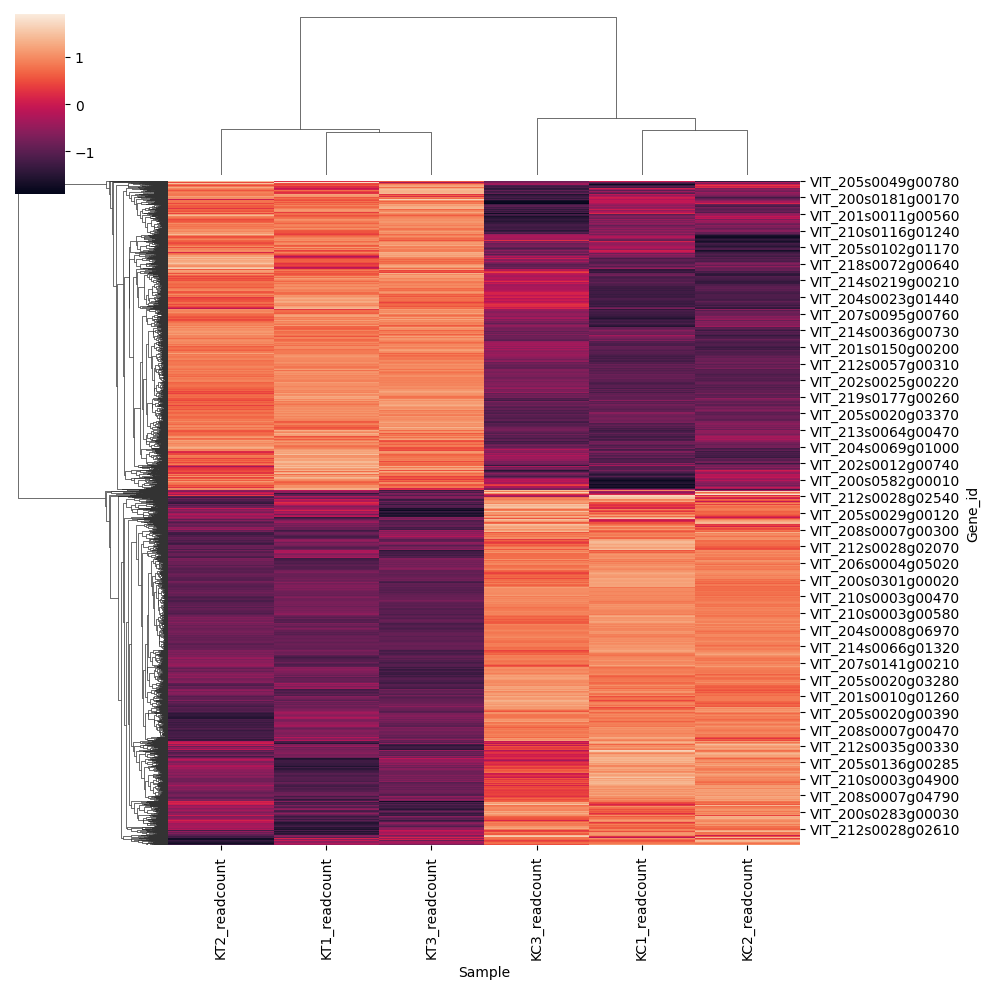

In [20]:
sns.clustermap(kheat_graph, z_score=0)

A:\python3.10\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
A:\python3.10\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


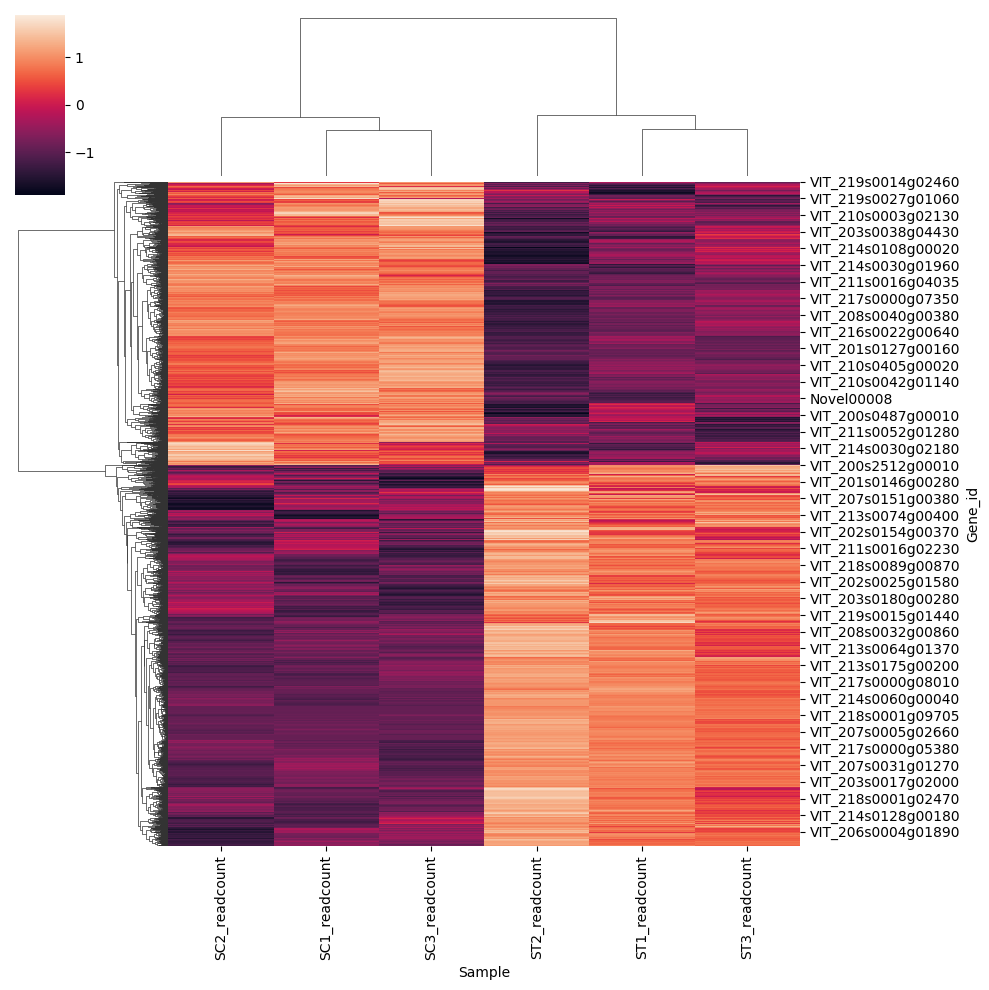

In [21]:
sns.clustermap(smheat_graph, z_score=0)

## Gene Annotation using sanbomics
To Download gene data of the organism by:
* Select `Gene` on database on NCBI and,
* Type `genetype protein coding[Properties] AND "29760"[Taxonomy ID] AND alive[property]` on NCBI search bar

In [4]:
geneset = pd.read_table("gene_result.txt")
geneset = geneset.drop(columns=['CurrentID', 'Status', 'map_location', 'OMIM', 'Unnamed: 17'])
geneset.head()

tax_id        Org_name     GeneID  Symbol  \
0   29760  Vitis vinifera  100256566  VINST1   
1   29760  Vitis vinifera  100233099    UFGT   
2   29760  Vitis vinifera  100232982    LAR1   
3   29760  Vitis vinifera  100245286    CBF4   
4   29760  Vitis vinifera  100233134   FAOMT   

                                             Aliases  \
0   VIT_00010554001, PSV25, RS, RS1, RS3, STS2, VST1   
1  VIT_00024419001, AlUFGT1, AlUFGT2, FlUFGT1, Fl...   
2                                    VIT_00011958001   
3                   VIT_00010631001, CBF17, DREBA1-1   
4                    VIT_00010469001, OMT3.1, VvAOMT   

                               description  \
0                        stilbene synthase   
1  anthocyanidin 3-O-glucosyltransferase 2   
2           leucoanthocyanidin reductase 1   
3                CBF4 transcription factor   
4          anthocyanin O-methyltransferase   

                                  other_designations chromosome  \
0  stilbene synthase 1|Resveratrol synthase 1|StS...         16   
1  anthocyanidin 3-O-glucosyltransferase UFGT|3-O...         16   
2  leucoanthocyanidin reductase 1|leucoanthocyani...          1   
3  dehydration-responsive element-binding protein...         16   
4  flavonoid 3',5'-methyltransferase|Anthocyanin-...          1   

  genomic_nucleotide_accession.version  \
0                          NC_081820.1   
1                          NC_081820.1   
2                          NC_081805.1   
3                          NC_081820.1   
4                          NC_081805.1   

   start_position_on_the_genomic_accession  \
0                               21514553.0   
1                                2304255.0   
2                                2592021.0   
3                               20597422.0   
4                               25582082.0   

   end_position_on_the_genomic_accession orientation  exon_count  
0                             21516095.0       minus         2.0  
1                              2305808.0       minus         2.0  
2                              2595024.0       minus         5.0  
3                             20598542.0       minus         1.0  
4                             25584228.0        plus         5.0

In [40]:
backgroundGenes = pd.DataFrame(data=[geneset.Symbol, geneset.Aliases, 
                               geneset.description, geneset.other_designations]).T
backgroundGenes.head()

Symbol                                            Aliases  \
0  VINST1   VIT_00010554001, PSV25, RS, RS1, RS3, STS2, VST1   
1    UFGT  VIT_00024419001, AlUFGT1, AlUFGT2, FlUFGT1, Fl...   
2    LAR1                                    VIT_00011958001   
3    CBF4                   VIT_00010631001, CBF17, DREBA1-1   
4   FAOMT                    VIT_00010469001, OMT3.1, VvAOMT   

                               description  \
0                        stilbene synthase   
1  anthocyanidin 3-O-glucosyltransferase 2   
2           leucoanthocyanidin reductase 1   
3                CBF4 transcription factor   
4          anthocyanin O-methyltransferase   

                                  other_designations  
0  stilbene synthase 1|Resveratrol synthase 1|StS...  
1  anthocyanidin 3-O-glucosyltransferase UFGT|3-O...  
2  leucoanthocyanidin reductase 1|leucoanthocyani...  
3  dehydration-responsive element-binding protein...  
4  flavonoid 3',5'-methyltransferase|Anthocyanin-...

In [29]:
kyohoDegs = pd.read_csv("B:/Major_project/Workspace/GSE129046_family/Analysis/kyohoDifferentiallySigs.csv")
shineDegs = pd.read_csv("B:/Major_project/Workspace/GSE129046_family/Analysis/ShineMuscatDifferentiallySigs.csv")

In [ ]:
symbolList = []
for i in range(len(kyohoDegs.Gene_id)):
    for j in range(len(backgroundGenes.Aliases)):
        alst = str(backgroundGenes.Aliases[j]).split(',')
        if kyohoDegs.Gene_id[i] in alst:
            symbolList.append(backgroundGenes.Symbol[j])
        else:
            symbolList.append('--')


## GSEA (Gene Set Enrichment Analysis) using GSEApy
### ERROR....

In [22]:
k_sigs['Rank'] = -np.log10(k_sigs.padj)*k_sigs.log2FoldChange
sm_sigs['Rank'] = -np.log10(sm_sigs.padj)*sm_sigs.log2FoldChange
k_sorted_sigs = k_sigs.reset_index()
sm_sorted_sigs = sm_sigs.reset_index()

kranking = k_sorted_sigs[['Gene_id', 'stat']].dropna().sort_values('stat', ascending=False)
kranking['Gene_id'] = kranking['Gene_id'].apply(lambda u: u.upper())
kranking = kranking.drop_duplicates('Gene_id')

smranking = sm_sorted_sigs[['Gene_id', 'stat']].dropna().sort_values('stat', ascending=False)
smranking['Gene_id'] = smranking['Gene_id'].apply(lambda u: u.upper())
smranking = smranking.drop_duplicates('Gene_id')

A:\python3.10\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\lenovo\AppData\Local\Temp\ipykernel_856\994911718.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  k_sigs['Rank'] = -np.log10(k_sigs.padj)*k_sigs.log2FoldChange
C:\Users\lenovo\AppData\Local\Temp\ipykernel_856\994911718.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sm_sigs['Rank'] = -np.log10(sm_sigs.padj)*sm_sigs.log2FoldCha

### Name: Aniket Yadav
#### ID: 20BTBINF003